<a href="https://colab.research.google.com/github/hygo2025/ciencia_de_dados/blob/main/trabalho_pratico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [275]:
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AeYgV89TmYvNC__RDXr8hS0P6WOsChWg' -O filmes.csv

In [276]:
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install nltk
# !pip install numpy
# !pip install scikit-learn
# !pip install plotly

In [286]:
import pandas as pd

import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as hierarchy

import warnings
warnings.filterwarnings("ignore")
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /home/hygo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [312]:
def load_data(sample_frac: float = 0.5) -> pd.DataFrame:
    df_raw = pd.read_csv("filmes.csv")
    genre_counts = df_raw['genres'].value_counts()
    valid_genres = genre_counts[genre_counts >= 50].index
    df_filtered = df_raw[df_raw['genres'].isin(valid_genres)]
    df_raw = df_filtered.groupby('genres', group_keys=False).apply(lambda x: x.sample(frac=sample_frac, random_state=42))
    # df_raw = df_filtered.groupby('genres', group_keys=False).apply(
    #     lambda x: x.sample(n=50, random_state=42)
    # )
    return df_raw

In [279]:
from src.pre_process import PreProccessText

column_original = 'sinopse'
column_preprocessed = 'sinopse_preprocessed'

def load_data_and_preprocess(sample_frac: float = 0.5) -> pd.DataFrame:
    df = load_data(sample_frac)
    pre_proccess_text = PreProccessText()
    df[column_preprocessed] = df[column_original].apply(pre_proccess_text.run)
    return df


In [280]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

class TfIdf:
    def __init__(self,
                 max_df: float = 0.95,
                 min_df: int = 2,
                 ngram_range: tuple = (1, 3)
                 ):
        self.vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, ngram_range=ngram_range)

    def run(self, df: pd.DataFrame, column_name: str) -> pd.DataFrame:
        return self.vectorizer.fit_transform(df[column_name])

    def count_feature_names_out(self) -> int:
        return len(self.vectorizer.get_feature_names_out())

    def to_array(self, tfidf_matrix: pd.DataFrame) -> pd.DataFrame:
        return tfidf_matrix.toarray()

In [301]:
def plot_scatter_tfidf(df, tfidf_reduced, n_components=2):
    fig = px.scatter(
        df,
        x=tfidf_reduced[:, 0],
        y=tfidf_reduced[:, 1],
        color='genres',           # Mapeia a coluna 'genres' para as cores
        symbol='cluster',         # Diferencia os clusters com símbolos
        hover_data=['genres'],
        title=f"Clustering Hierárquico com TF-IDF ({n_components} componentes) e Gêneros"
    )

    fig.update_layout(xaxis_visible=False, yaxis_visible=False)

    fig.show()


def plot_genres_by_cluster(df_raw):
    genre_cluster = df_raw.groupby(['cluster', 'genres']).size().reset_index(name='count')

    pivot = genre_cluster.pivot(index='cluster', columns='genres', values='count').fillna(0)

    pivot.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')

    plt.title('Distribuição de Gêneros por Cluster', fontsize=16)
    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Quantidade', fontsize=14)
    plt.legend(title='Gêneros', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [282]:
def load_data_and_preprocess_tfidf(sample_frac: float = 0.5):
    df = load_data_and_preprocess(sample_frac)
    tf_idf = TfIdf()
    tf_idf_matrix = tf_idf.run(df, column_preprocessed)
    tf_idf_array = tf_idf.to_array(tf_idf_matrix)
    return df, tf_idf_matrix, tf_idf_array


In [287]:
def make_svd(df, tf_idf_matrix, n_components=6):
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    tfidf_reduced = svd.fit_transform(tf_idf_matrix)

    return df, tfidf_reduced

def make_pca(df, tf_idf_matrix, n_components=6):
    pca = PCA(n_components=n_components, random_state=42)
    tfidf_reduced = pca.fit_transform(tf_idf_matrix)

    return df, tfidf_reduced

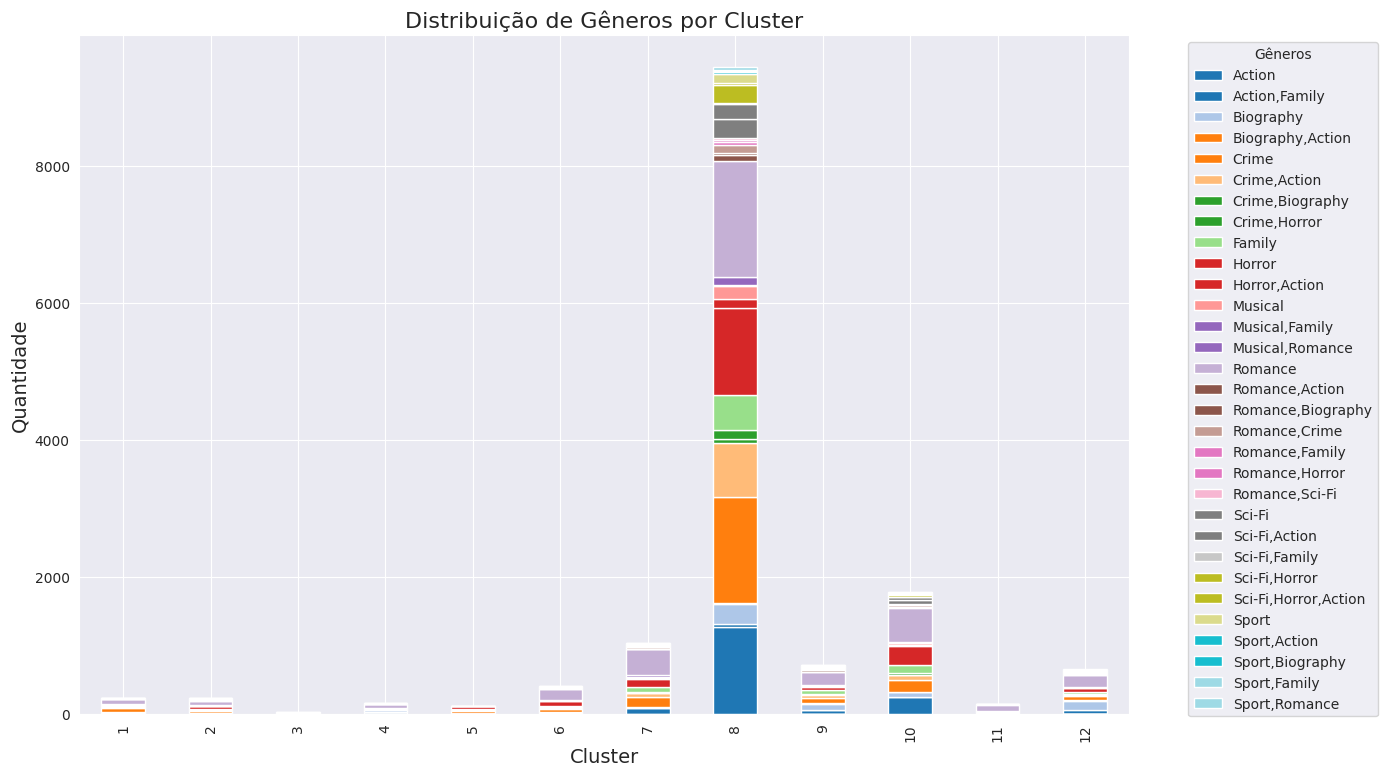

In [314]:
df, tf_idf_matrix, tf_idf_array = load_data_and_preprocess_tfidf()
n_components = 12
df, tfidf_reduced = make_pca(df, tf_idf_matrix, n_components=n_components)

cluster_size = 12
Z = hierarchy.linkage(tfidf_reduced, method='complete')
clusters = hierarchy.fcluster(Z, t=cluster_size, criterion='maxclust')
df['cluster'] = clusters

# plot_scatter_tfidf(df, tfidf_reduced, n_components=cluster_size)

plot_genres_by_cluster(df)

df, tf_idf_matrix, tf_idf_array = load_data_and_preprocess_tfidf()


In [284]:
n_components = 5
svd = TruncatedSVD(n_components=n_components, random_state=42)
tfidf_reduced = svd.fit_transform(tf_idf_matrix)

# 4. Realizar o agrupamento com AgglomerativeClustering usando os 5 componentes
#    Aqui, definimos, por exemplo, 3 clusters e usamos o linkage 'complete'
agg_cluster = AgglomerativeClustering(n_clusters=6, linkage='average')
clusters = agg_cluster.fit_predict(tfidf_reduced)

plot_scatter_tfidf(df, tfidf_reduced, n_components=n_components)


ValueError: Value of 'symbol' is not the name of a column in 'data_frame'. Expected one of ['genres', 'averageRating', 'numVotes', 'sinopse', 'primaryTitle', 'startYear', 'runtimeMinutes', 'actors_names', 'directors_names', 'sinopse_preprocessed'] but received: cluster

In [270]:
# Vamos ver a distribuição dos gêneros em cada cluster obtido pelo K-Means:
print("Distribuição de gêneros por cluster):")
df.groupby('cluster')['genres'].value_counts()

Distribuição de gêneros por cluster):


cluster  genres         
0        Romance            610
         Crime              430
         Horror             382
         Action             354
         Crime,Action       199
                           ... 
4        Musical              1
         Musical,Family       1
         Musical,Romance      1
         Romance,Horror       1
5        Biography            2
Name: count, Length: 64, dtype: int64

In [268]:
def separar_generos(genres_str):
    return [g.strip() for g in genres_str.split(',')]

# Criando uma nova coluna que é uma lista de gêneros
df['lista_generos'] = df['genres'].apply(separar_generos)

# Explodindo a lista para análise detalhada
df_exploded = df.explode('lista_generos')

print("Distribuição de gêneros (explodida) por cluster (K-Means):")
df_exploded.groupby('cluster')['lista_generos'].value_counts()




Distribuição de gêneros por cluster (K-Means):
cluster  genres         
0        Romance            610
         Crime              430
         Horror             382
         Action             354
         Crime,Action       199
                           ... 
4        Musical              1
         Musical,Family       1
         Musical,Romance      1
         Romance,Horror       1
5        Biography            2
Name: count, Length: 64, dtype: int64
Distribuição de gêneros (explodida) por cluster (K-Means):
